In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
#nltk.download('stopwords')
#nltk.download('wordnet')
import re

#from textblob import TextBlob
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot
from keras.models import Sequential
from keras.layers import Embedding, Flatten, Dense, Lambda
from keras.layers.normalization import BatchNormalization
from keras.backend import mean
from keras.utils import to_categorical
from keras import optimizers, initializers, regularizers
from keras import backend as K

from load_glove_embeddings import load_glove_embeddings

In [2]:
# Import GloVe embeddings
word2index, embedding_matrix = load_glove_embeddings('../../glove.twitter.27B/glove.twitter.27B.200d.txt', embedding_dim=200)

In [3]:
# Import data
df = pd.read_csv("../data/processed_data/jokes_dataset_CLEAN.csv")
df = df.drop(columns="Unnamed: 0")
df.head()

,body,id,score,title
0,"Now I have to say ""Leroy can you please paint ...",5tz52q,1,I hate how you cant even say black paint anymore
1,Pizza doesn't scream when you put it in the ov...,5tz4dd,0,What's the difference between a Jew in Nazi Ge...
2,...and being there really helped me learn abou...,5tz319,0,I recently went to America....
3,He got caught trying to sell the two books to ...,5tz1pc,0,You hear about the University book store worke...
4,Because the p is silent.,5tz1o1,0,Why is it unknown on how pterodactyls urinate ...


In [4]:
def preprocess(words, to_lowercase=True, remove_punctuation=False, remove_digits=False, 
               remove_odd_chars=True, remove_stopwords=False, stem=False, spell_check=False,
               lemmatize=False):
    
    if to_lowercase:
        words = [w.lower() for w in words]
    
    if remove_punctuation:
        words = [w for w in words if not (re.match(r'^\W+$', w) != None)]
    
    if remove_digits:
        words = [w for w in words if not w.replace('.','',1).isdigit()]

    if remove_odd_chars:
        words = [re.sub(r'[^a-zA-Z0-9_]','', w) for w in words]
    
    if remove_stopwords:
        sw = set(nltk.corpus.stopwords.words("english"))
        words = [w for w in words if not w in sw]

    if spell_check:
        words = [str(TextBlob(w).correct()) for w in words]
     
    if stem:
        porter = nltk.PorterStemmer()
        words = [porter.stem(w) for w in words]

    if lemmatize:
        wordnet = nltk.WordNetLemmatizer()
        words = [wordnet.lemmatize(w) for w in words]
        
    return words

def lookup_index(docs):
    output_matrix = []
    oov = 0
    tot = 0
    for d in docs:
        indices = []
        for w in d:
            tot +=1
            if w in word2index.keys():
                indices.append(word2index[w])
            else:
                oov += 1
                indices.append(word2index['unk'])
        output_matrix.append(indices)
    return output_matrix, float(oov)/tot

In [5]:
def precision(y_true, y_pred):	
    """Precision metric.	
    Only computes a batch-wise average of precision. Computes the precision, a
    metric for multi-label classification of how many selected items are
    relevant.
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))	
    precision = true_positives / (predicted_positives + K.epsilon())	
    return precision

def recall(y_true, y_pred):	
    """Recall metric.	
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """	
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))	
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))	
    recall = true_positives / (possible_positives + K.epsilon())	
    return recall

def f1_score(y_true, y_pred):
    """Computes the F1 Score
    Only computes a batch-wise average of recall. Computes the recall, a metric
    for multi-label classification of how many relevant items are selected.	
    """
    p = precision(y_true, y_pred)
    r = recall(y_true, y_pred)
    return (2 * p * r) / (p + r + K.epsilon())

In [137]:
# Define classes for classification
df['class'] = [0 if df.score[i] <= 3 \
               else 1 if (df.score[i] > 3 and df.score[i] <= 20) \
               else 2 for i in range(df.shape[0])]
print(df['class'].value_counts())
#else 2 if (df.score[i] > 20 and df.score[i] <= 50) \

# Select an even sample of classes
even_sample = df[df['class']==0][:20000]
even_sample = even_sample.append(df[df['class']==1][:20000])
even_sample = even_sample.append(df[df['class']==2][:20000])
even_sample = even_sample.sample(frac=1).reset_index(drop=True)
print(even_sample['class'].value_counts())

# Concatonate set-up and punchline
docs = [str(even_sample.title[i]) + ' ' + str(even_sample.body[i]) for i in range(even_sample.shape[0])]

# Pre-process lowercasing, removing odd characters etc.
docs_cleaned = [preprocess(words.split()) for words in docs]

# Encode words and print out of vocab proportion
docs_encoded, oov = lookup_index(docs_cleaned)
print(oov)

# Pad sentences to length of 60
docs_padded = pad_sequences(docs_encoded, maxlen=60, padding='post')

0    83376
1    35129
2    27336
Name: class, dtype: int64
2    20000
1    20000
0    20000
Name: class, dtype: int64
0.026435812438126365


In [128]:
initializers.glorot_uniform()

embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1], 
                            input_length=60,
                            weights=[embedding_matrix], 
                            trainable=False,
                            mask_zero=False, #set to true to ignore zeros in mean
                            name='embedding_layer')

model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Lambda(lambda x: mean(x, axis=1)))
#model.add(Dense(200, activation='relu'))
#model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu', input_dim=12000))
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu', input_dim=128))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu', input_dim=64))
model.add(Dense(3, activation='softmax', input_dim=32)) #kernel_regularizer=regularizers.l2(0.1)

adam = optimizers.adam(lr=0.001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1_score])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 60, 200)           238703000 
_________________________________________________________________
flatten_25 (Flatten)         (None, 12000)             0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 12000)             48000     
_________________________________________________________________
dense_93 (Dense)             (None, 128)               1536128   
_________________________________________________________________
dense_94 (Dense)             (None, 64)                8256      
_________________________________________________________________
batch_normalization_55 (Batc (None, 64)                256       
_________________________________________________________________
dense_95 (Dense)             (None, 32)                2080      
__________

In [129]:
results = model.fit(docs_padded, to_categorical(even_sample['class']), validation_split=0.3, batch_size=20, epochs=20)

Train on 42000 samples, validate on 18000 samples
Epoch 1/20
42000/42000 [==============================] - 99s 2ms/step - loss: 1.1072 - acc: 0.3633 - precision: 0.2353 - recall: 0.0243 - f1_score: 0.0419 - val_loss: 1.0978 - val_acc: 0.3737 - val_precision: 0.3454 - val_recall: 0.0361 - val_f1_score: 0.0639
Epoch 2/20
42000/42000 [==============================] - 83s 2ms/step - loss: 1.0855 - acc: 0.3930 - precision: 0.3687 - recall: 0.0360 - f1_score: 0.0641 - val_loss: 1.0922 - val_acc: 0.3804 - val_precision: 0.3685 - val_recall: 0.0342 - val_f1_score: 0.0613
Epoch 3/20
42000/42000 [==============================] - 82s 2ms/step - loss: 1.0670 - acc: 0.4214 - precision: 0.5035 - recall: 0.0745 - f1_score: 0.1257 - val_loss: 1.0894 - val_acc: 0.3949 - val_precision: 0.4254 - val_recall: 0.0511 - val_f1_score: 0.0890
Epoch 4/20
42000/42000 [==============================] - 83s 2ms/step - loss: 1.0450 - acc: 0.4542 - precision: 0.5690 - recall: 0.1365 - f1_score: 0.2151 - val_loss:

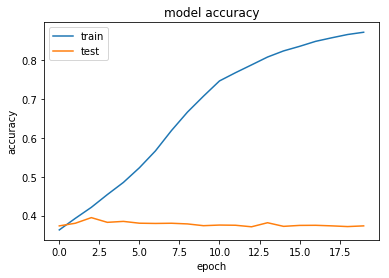

In [130]:
# accuracy results
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

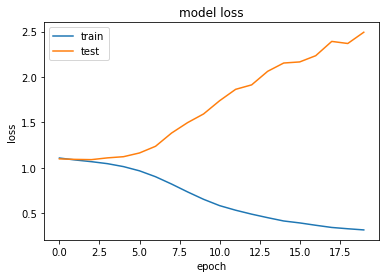

In [131]:
# loss results
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [148]:
K.clear_session()
initializers.glorot_uniform()
reg_pen = 0.01


embedding_layer = Embedding(input_dim=embedding_matrix.shape[0],
                            output_dim=embedding_matrix.shape[1], 
                            input_length=60,
                            weights=[embedding_matrix], 
                            trainable=False,
                            mask_zero=False, #set to true to ignore zeros in mean
                            name='embedding_layer')

model = Sequential()
model.add(embedding_layer)
model.add(Flatten())
model.add(BatchNormalization())
#model.add(Lambda(lambda x: mean(x, axis=1)))
#model.add(Dense(200, activation='relu'))
#model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu', input_dim=12000, kernel_regularizer=regularizers.l2(reg_pen)))
#model.add(BatchNormalization())
model.add(Dense(64, activation='relu', input_dim=128, kernel_regularizer=regularizers.l2(reg_pen)))
model.add(BatchNormalization())
model.add(Dense(32, activation='relu', input_dim=64, kernel_regularizer=regularizers.l2(reg_pen)))
model.add(Dense(3, activation='softmax', input_dim=32, kernel_regularizer=regularizers.l2(reg_pen))) #

adam = optimizers.adam(lr=0.0001)
model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy', precision, recall, f1_score])
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_layer (Embedding)  (None, 60, 200)           238703000 
_________________________________________________________________
flatten_1 (Flatten)          (None, 12000)             0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 12000)             48000     
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1536128   
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
batch_normalization_2 (Batch (None, 64)                256       
_________________________________________________________________
dense_3 (Dense)              (None, 32)                2080      
__________

In [149]:
results = model.fit(docs_padded, to_categorical(even_sample['class']), validation_split=0.3, batch_size=30, epochs=10)

Train on 42000 samples, validate on 18000 samples
Epoch 1/10
42000/42000 [==============================] - 60s 1ms/step - loss: 3.9484 - acc: 0.3571 - precision: 0.3626 - recall: 0.0563 - f1_score: 0.0899 - val_loss: 3.0428 - val_acc: 0.3682 - val_precision: 0.2989 - val_recall: 0.0195 - val_f1_score: 0.0360
Epoch 2/10
42000/42000 [==============================] - 56s 1ms/step - loss: 2.4737 - acc: 0.4115 - precision: 0.4879 - recall: 0.0511 - f1_score: 0.0903 - val_loss: 2.0865 - val_acc: 0.3801 - val_precision: 0.4355 - val_recall: 0.0546 - val_f1_score: 0.0949
Epoch 3/10
42000/42000 [==============================] - 56s 1ms/step - loss: 1.8392 - acc: 0.4301 - precision: 0.5351 - recall: 0.0846 - f1_score: 0.1429 - val_loss: 1.7436 - val_acc: 0.3833 - val_precision: 0.4442 - val_recall: 0.0758 - val_f1_score: 0.1269
Epoch 4/10
42000/42000 [==============================] - 56s 1ms/step - loss: 1.5671 - acc: 0.4499 - precision: 0.5612 - recall: 0.1166 - f1_score: 0.1889 - val_loss:

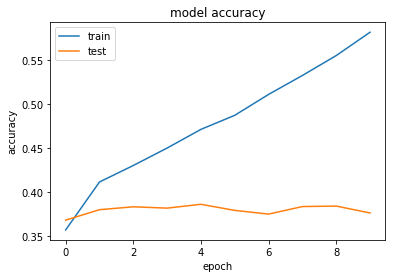

In [150]:
# accuracy results
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

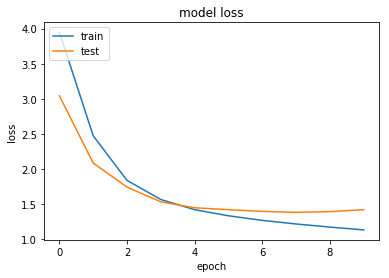

In [151]:
# loss results
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()